# Exemple avec plusieurs stratégies

## Importation du package et Lecture du fichier de données

In [1]:
# import nécessaire au fonctionnement du package
from mypackage import Strategy_Manager, Strategy, strategy, DataFileReader

# import supplémentaire pour les stratégies utilisées comme exemple
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
# Chemin vers le fichier de données sous format .csv ou .parquet
filepath = 'fichier_donnée.csv' 

# Initialiser le lecteur de fichiers en indiquant le format des dates
reader = DataFileReader(date_format='%d/%m/%Y') 

# Lecture du fichier
data = reader.read_file(filepath, date_column='Date_Price')
data

,AAVEUSDT,ACMUSDT,ADAUSDT,ADXUSDT,AGLDUSDT,ALGOUSDT,ALICEUSDT,ALPACAUSDT,ALPHAUSDT,AMPUSDT,...,BATUSDT,BCHUSDT,BEAMUSDT,BELUSDT,BETAUSDT,BICOUSDT,BLZUSDT,BNBUPUSDT,BNBUSDT,BNTUSDT
Date_Price,,,,,,,,,,,,,,,,,,,,,
2022-01-01,266.4,5.211,1.3800,0.5729,1.705,1.7414,13.380,0.6264,0.6995,0.04964,...,1.2560,444.8,0.5862,1.651,0.64700,4.480,0.2208,543.00,527.3,3.345
2022-01-02,265.3,5.195,1.3770,0.5799,1.828,1.6734,13.060,0.6085,0.6978,0.04897,...,1.2999,447.7,0.6011,1.667,0.68177,4.223,0.2258,552.62,531.0,3.396
2022-01-03,267.2,5.152,1.3190,0.5798,1.718,1.7949,12.640,0.6186,0.7019,0.05239,...,1.3017,434.7,0.5934,1.616,0.63450,3.892,0.2273,506.38,511.9,3.428
2022-01-04,252.1,5.107,1.3090,0.5613,1.637,1.6725,13.650,0.6163,0.6981,0.04929,...,1.2825,427.1,0.5864,1.646,0.63164,3.920,0.2219,494.10,506.9,3.401
2022-01-05,230.3,4.727,1.2300,0.5276,1.570,1.5554,12.230,0.5660,0.6276,0.04682,...,1.1764,399.4,0.5339,1.465,0.57229,3.553,0.2064,411.33,474.1,3.297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,56.0,2.346,0.2652,0.1212,0.270,0.1715,1.091,0.2529,0.0801,0.00318,...,0.1869,103.4,0.1167,0.405,0.07050,0.284,0.0534,28.24,244.3,0.343
2022-12-27,57.5,2.345,0.2603,0.1182,0.264,0.1701,1.093,0.2504,0.0786,0.00312,...,0.1788,101.7,0.1164,0.401,0.06771,0.274,0.0531,28.76,246.7,0.339
2022-12-28,53.8,2.288,0.2482,0.1143,0.259,0.1670,1.058,0.2477,0.0762,0.00309,...,0.1680,99.2,0.1107,0.386,0.06701,0.264,0.0523,28.27,244.5,0.329


## Création de plusieurs stratégies

In [3]:
# Création d'une stratégie par héritage
class MovingAverageCrossover(Strategy):
    """Stratégie de croisement de moyennes mobiles pour plusieurs actifs."""
    
    def __init__(self, assets, short_window=20, long_window=50, rebalancing_frequency='D', 
                 allocation_method='equal'):
        super().__init__(rebalancing_frequency=rebalancing_frequency, assets=assets)
        self.short_window = short_window
        self.long_window = long_window
        self.allocation_method = allocation_method

    def get_position(self, historical_data, current_position):
        if len(historical_data) < self.long_window:
            return {asset: 0 for asset in self.assets}
        
        signals = {}
        for asset in self.assets:
            short_ma = historical_data[asset].rolling(self.short_window).mean()
            long_ma = historical_data[asset].rolling(self.long_window).mean()
            signals[asset] = 1 if short_ma.iloc[-1] > long_ma.iloc[-1] else -1
        
        # Allocation des positions selon la méthode choisie
        if self.allocation_method == 'equal':
            position_size = 1.0 / len(self.assets)
            positions = {asset: signal * position_size for asset, signal in signals.items()}
        else:  # 'signal_weighted'
            total_signals = sum(abs(signal) for signal in signals.values())
            positions = {asset: signal / total_signals for asset, signal in signals.items()}
            
        return positions

In [4]:
# Création d'une stratégie simple avec décorateur
@strategy
def momentum_strategy(historical_data, current_position, assets, rebalancing_frequency, chosen_window=20):
    """
    Cette stratégie mesure le momentum basé sur les variations de prix sur une fenêtre donnée.
    Elle prend une position long si le rendement est positif, et short s'il est négatif.

    Args:
        historical_data (pd.DataFrame): Données historiques avec les prix des actifs.
        current_position (dict): Positions actuelles sur les actifs.
        assets (list): Liste des actifs à trader.
        rebalancing_frequency (str): Fréquence de rééquilibrage ('D', 'W', etc.).
        chosen_window (int): Fenêtre de temps pour le calcul du momentum (en périodes).
    
    Returns:
        dict: Positions pondérées pour chaque actif.
    """
    
    # Vérifie si suffisamment de données sont disponibles pour la fenêtre choisie
    if len(historical_data) < chosen_window:
        return {asset: 0 for asset in assets}

    positions = {}
    active_assets = []  # Liste pour enregistrer les actifs ayant des signaux valides
    
    for asset in assets:
        # Calcul du rendement sur la fenêtre choisie (momentum)
        # Le rendement est calculé comme la variation en pourcentage entre la valeur à la fin de la fenêtre et celle du début.
        asset_data = historical_data[asset]
        
        if len(asset_data) >= chosen_window:
            returns = (asset_data.iloc[-1] - asset_data.iloc[-chosen_window]) / asset_data.iloc[-chosen_window]
        else:
            returns = None  # Si on n'a pas assez de données
        # Vérifie si le rendement est valide (non-NaN)
        if pd.isna(returns) or returns == 0:
            positions[asset] = 0
        else:
            # Génère un signal : 1 si momentum positif, -1 si négatif
            signal = 1 if returns > 0 else -1
            positions[asset] = signal
            active_assets.append(asset)
    return positions

In [5]:
class MCOBasedStrategy(Strategy):
    """
    Stratégie basée sur la déviation du prix actuel par rapport au coût moyen des actifs.
    Une forte déviation positive conduit à une position short, une forte déviation négative à une position long.
    """

    def __init__(self, assets, threshold: float = 0.05, initial_position_costs: dict = None, rebalancing_frequency: str = 'D'):
        """
        Initialise la stratégie.

        :param assets: Liste des actifs à trader.
        :param threshold: Seuil de déviation du prix pour prendre une position.
        :param initial_position_costs: Coûts moyens initiaux pour chaque actif.
        :param rebalancing_frequency: Fréquence de rééquilibrage ('D', 'W', etc.).
        """
        super().__init__(rebalancing_frequency=rebalancing_frequency, assets=assets)
        self.threshold = threshold
        self.average_costs = None
        self.initial_position_costs = initial_position_costs or {asset: 0 for asset in assets}

    def fit(self, data: pd.DataFrame) -> None:
        """
        Initialise les coûts moyens pour chaque actif.

        :param data: Données historiques utilisées pour initialiser la stratégie.
        """
        self.average_costs = self.initial_position_costs.copy()

    def update_average_cost(self, asset: str, executed_price: float, executed_quantity: float, current_position: float) -> None:
        """
        Met à jour le coût moyen pour un actif spécifique après une transaction.

        :param asset: Nom de l'actif.
        :param executed_price: Prix d'exécution de la transaction.
        :param executed_quantity: Quantité exécutée.
        :param current_position: Position actuelle avant la transaction.
        """
        new_position = current_position + executed_quantity
        if new_position == 0:
            self.average_costs[asset] = self.initial_position_costs[asset]
        else:
            self.average_costs[asset] = (
                (self.average_costs[asset] * current_position + executed_price * executed_quantity) / new_position
            )

    def get_position(self, historical_data: pd.DataFrame, current_position: dict) -> dict:
        """
        Calcule les positions basées sur la déviation du prix par rapport au coût moyen.

        :param historical_data: Données historiques avec les prix des actifs.
        :param current_position: Positions actuelles des actifs.
        :return: Dictionnaire des positions calculées.
        """
        if self.average_costs is None:
            raise ValueError("Les coûts moyens doivent être initialisés avec la méthode fit().")
        
        positions = {}
        active_assets = []
        
        for asset in self.assets:
            if historical_data[asset].empty:
                positions[asset] = 0
                continue

            current_price = historical_data[asset].iloc[-1]
            if pd.isna(current_price):
                positions[asset] = 0
                continue

            avg_cost = self.average_costs[asset]
            if avg_cost == 0:  # Éviter la division par zéro
                positions[asset] = 0
                continue

            price_deviation = (current_price - avg_cost) / avg_cost

            if price_deviation > self.threshold:
                positions[asset] = -1  # Position short
                active_assets.append(asset)
            elif price_deviation < -self.threshold:
                positions[asset] = 1  # Position long
                active_assets.append(asset)
            else:
                positions[asset] = 0
        
        # Ajuster les positions pour une allocation égale
        if active_assets:
            position_size = 1.0 / len(active_assets)
            for asset in active_assets:
                positions[asset] *= position_size
                
        return positions


In [6]:
# Stratégie basée sur les Moindres Carrés Ordinaires (MCO)
class OrdinaryLeastSquaresStrategy(Strategy):
    """
    Stratégie utilisant les Moindres Carrés Ordinaires (MCO) pour prédire les tendances des prix.

    Ajuste la position selon l'écart relatif entre le prix actuel et le prix prévu par une régression linéaire.
    """
    def __init__(self, assets, window_size=20, threshold=0.01, rebalancing_frequency='D'):
        """
        Initialise la stratégie avec les paramètres donnés.

        :param window_size: Nombre de périodes pour la fenêtre de régression.
        :param threshold: Seuil pour déclencher une position (en pourcentage).
        :param rebalancing_frequency: Fréquence de rééquilibrage ('D', 'W', etc.).
        """
        super().__init__(rebalancing_frequency=rebalancing_frequency, assets=assets)
        self.window_size = window_size
        self.threshold = threshold

    def get_position(self, historical_data, current_position):
        """
        Calcule les positions pour chaque actif en fonction de l'écart entre le prix actuel et le prix prévu.

        :param historical_data: Données historiques des actifs sous forme de DataFrame.
        :param current_position: Positions actuelles pour chaque actif.
        :return: Dictionnaire des nouvelles positions.
        """
        positions = {}
        for asset in self.assets:
            asset_data = historical_data[asset]
            if len(asset_data) < self.window_size:
                # Pas assez de données pour effectuer la régression
                positions[asset] = 0
                continue

            # Préparation des données pour la régression linéaire
            prices = asset_data.iloc[-self.window_size:].values.reshape(-1, 1)
            time = np.arange(self.window_size).reshape(-1, 1)

            # Ajustement du modèle linéaire
            model = LinearRegression()
            model.fit(time, prices)
            # Prédiction du prix actuel
            predicted_price = model.predict([[self.window_size]])[0]
            current_price = asset_data.iloc[-1]
            price_deviation = (current_price - predicted_price) / predicted_price

            # Génération des signaux de position
            if price_deviation > self.threshold:
                positions[asset] = -1
            elif price_deviation < -self.threshold:
                positions[asset] = 1
            else:
                positions[asset] = 0
        return positions

In [7]:
class DayVariationStrategy(Strategy):
    """
    Stratégie qui consiste à prendre une position :
    - long lorsque le prix augmente sur les deux derniers jours.
    - short lorsque le prix diminue sur les deux derniers jours.
    Stratégie efficace lorsque la volatilité est faible et les tendances sont importantes.
    """
    def __init__(self, assets, rebalancing_frequency='D'):
        """
        Initialisation de la stratégie Day Variation.
        Args:
            assets: Liste des actifs à trader.
            rebalancing_frequency: Fréquence de rééquilibrage ('D', 'W', 'M', etc.).
        """
        super().__init__(rebalancing_frequency=rebalancing_frequency, assets=assets)

    def get_position(self, historical_data: pd.DataFrame, current_position: dict) -> dict:
        """
        Calcule les positions en fonction de la variation journalière.
        Args:
            historical_data: Données historiques contenant les prix des actifs.
            current_position: Positions actuelles.
        Returns:
            dict: Positions pour chaque actif (-1 ou 1).
        """
        if len(historical_data) < 2:
            # Pas assez de données pour calculer la variation
            return {asset: 0 for asset in self.assets}

        positions = {}
        for asset in self.assets:
            current_price = historical_data[asset].iloc[-1]
            previous_price = historical_data[asset].iloc[-2]
            positions[asset] = 1 if current_price > previous_price else -1

        return positions

## Mise en place des variables nécessaire aux backtests

In [8]:
# Création de la liste des actifs utilisé
all_asset = data.columns.to_list()

# Création des instances et exécution des backtests
ma_strat_default = MovingAverageCrossover(assets=all_asset, short_window=20, long_window=50)
ma_strat_weekly = MovingAverageCrossover(assets=all_asset, short_window=20, long_window=50, rebalancing_frequency='W')     # Weekly rebalancing
ma_strat_monthly = MovingAverageCrossover(assets=all_asset, short_window=20, long_window=50, rebalancing_frequency='ME')    # Monthly rebalancing

mom_strat_daily = momentum_strategy(assets=all_asset, chosen_window=10, rebalancing_frequency='D')
mom_strat_weekly = momentum_strategy(assets=all_asset, chosen_window=10, rebalancing_frequency='W')
mom_strat_monthly = momentum_strategy(assets=all_asset, chosen_window=10, rebalancing_frequency='ME')

day_var_strat_daily = DayVariationStrategy(assets=all_asset, rebalancing_frequency='D')

ols_strat = OrdinaryLeastSquaresStrategy(assets=all_asset, window_size=20, threshold=0.01)

initial_costs = {asset: 0.10 for asset in all_asset}
mco_strat_monthly = MCOBasedStrategy(
    assets=all_asset,
    threshold=0.02,
    initial_position_costs=initial_costs,
    rebalancing_frequency='ME'
)

transaction_cost = {'AAVEUSDT': 0.5, 'ACMUSDT': 0.2, 'ADAUSDT': 0.4, 'ADXUSDT': 0.6, 'AGLDUSDT': 0.7, 'ALGOUSDT': 0.001, 'ALICEUSDT': 0.8, 'ALPACAUSDT': 2, 'ALPHAUSDT': 0.8, 'AMPUSDT': 0.051}
slippage_cost = {'AAVEUSDT': 0.53, 'ACMUSDT': 0.03, 'ADAUSDT': 0.33, 'ADXUSDT': 0.63, 'AGLDUSDT': 0.73, 'ALGOUSDT': 0.001, 'ALICEUSDT': 0.8, 'ALPACAUSDT': 21, 'ALPHAUSDT': 0.8, 'AMPUSDT': 0.01}

transaction_cost_partiel = {'AAVEUSDT': 5, 'ACMUSDT': 2}

# Création des dictionnaires de coûts
transaction_cost = {'AAVEUSDT': 0.5, 'ACMUSDT': 0.2, 'ADAUSDT': 0.4, 'ADXUSDT': 0.6, 'AGLDUSDT': 0.7, 
                    'ALGOUSDT': 0.001, 'ALICEUSDT': 0.8, 'ALPACAUSDT': 2, 'ALPHAUSDT': 0.8, 'AMPUSDT': 0.051}
slippage_cost = {'AAVEUSDT': 0.53, 'ACMUSDT': 0.03, 'ADAUSDT': 0.33, 'ADXUSDT': 0.63, 'AGLDUSDT': 0.73, 
                 'ALGOUSDT': 0.001, 'ALICEUSDT': 0.8, 'ALPACAUSDT': 21, 'ALPHAUSDT': 0.8, 'AMPUSDT': 0.01}

# Création d'un dictionnaire des différentes stratégies à comparer avec 
#   en clé, le nom choisi de la stratégie
#   en valeur, un tuple contenant la stratégie, les coûts de transactions, les coûts de slippage
dico_strat = {
    'ma_strat_default': (ma_strat_default, 0.1, 0.2),
    'ma_strat_weekly': (ma_strat_weekly, transaction_cost_partiel, None),
    'ma_strat_monthly': (ma_strat_monthly, transaction_cost, slippage_cost),
    'mom_strat_daily': (mom_strat_daily, 0.002, 0.0005),
    'mom_strat_weekly': (mom_strat_weekly, 0.01, 0.004),
    'mom_strat_monthly': (mom_strat_monthly, 0.005, 0.003),
    'mco_strat_monthly': (mco_strat_monthly, 0.01, 0.004),
}
# stratégies supplémentaire séparées pour une question de visibilité des graphes par rapport aux autres stratégies
dico_strat_2 = {
    'day_var_strat_daily': (day_var_strat_daily, transaction_cost, slippage_cost),
    'ols_strat': (ols_strat, transaction_cost, slippage_cost),
}

# Création de l'instance utile à la comparaison
manager = Strategy_Manager(data, dico_strat)
manager2 = Strategy_Manager(data, dico_strat_2)

# Exécution des backtests
manager.run_backtests()
manager2.run_backtests()

c:\Users\lince\anaconda3\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\lince\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


## Résultat du Backtest

In [9]:
# Affichage des statistiques pour chaque stratégie
manager.print_statistics()
manager2.print_statistics()


Statistiques : 
                   total_return  annual_return  profit_factor  volatility  \
ma_strat_default        -0.1116        -0.0787         0.4151      0.0188   
ma_strat_weekly         -0.0647        -0.2724         0.1405      0.0455   
ma_strat_monthly        -0.2480        -0.9975         0.0019      0.3157   
mom_strat_daily          0.1245         0.0846         1.0855      0.5774   
mom_strat_weekly        -0.4131        -0.9206         0.4601      0.5059   
mom_strat_monthly       -0.0630        -0.7448         0.6412      0.6118   
mco_strat_monthly       -0.0004        -0.0083         0.9032      0.0179   

                   sharpe_ratio  max_drawdown  sortino_ratio  VaR_95%  \
ma_strat_default        -4.1853       -0.1123        -3.6176  -0.0022   
ma_strat_weekly         -5.9855       -0.0653        -3.9890  -0.0078   
ma_strat_monthly        -3.1591       -0.2480        -1.8092  -0.0474   
mom_strat_daily          0.1466       -0.5178         0.1735  -0.0503   
m

## Graphique

In [10]:
# Choix du backend utilisé pour les graphiques
backend = 'matplotlib' # 'plotly' # 'matplotlib' # 'seaborn'

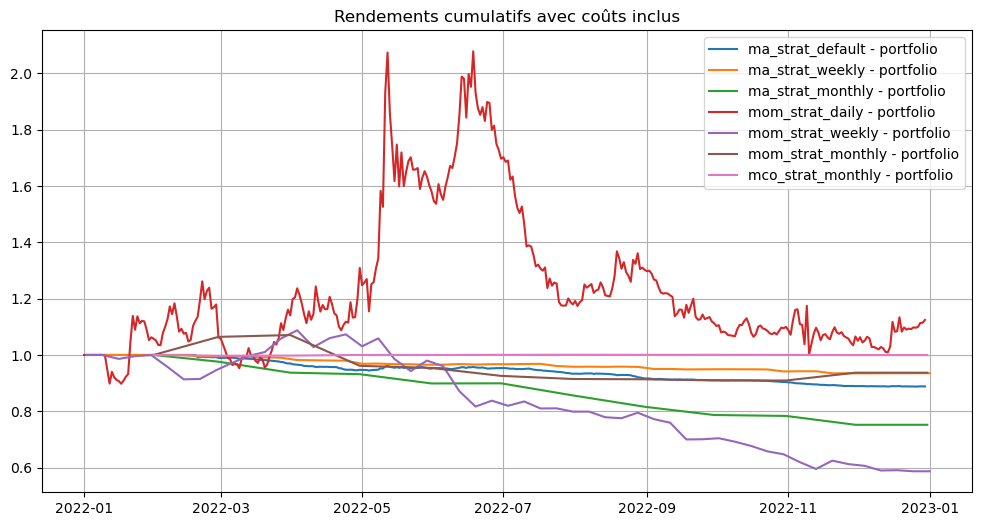

c:\Users\lince\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


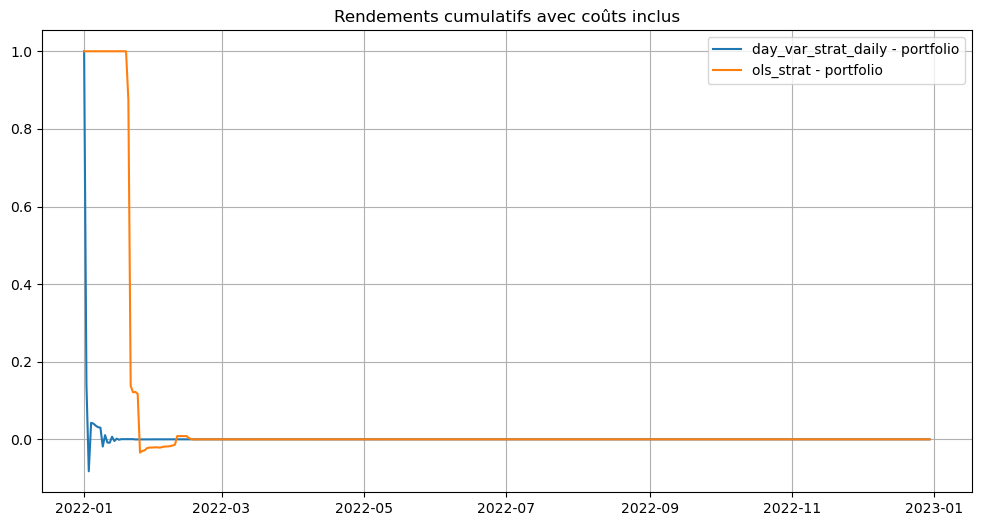

In [11]:
# Graphique des différentes stratégies avec possibilité d'inclusion de coûts 
manager.plot_all_strategies(backend=backend,include_costs=True)
manager2.plot_all_strategies(backend=backend,include_costs=True)

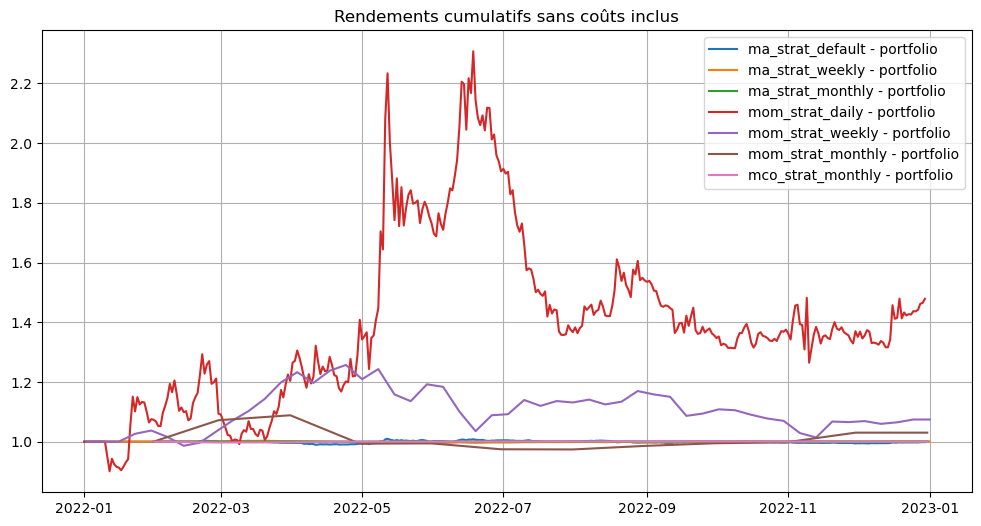

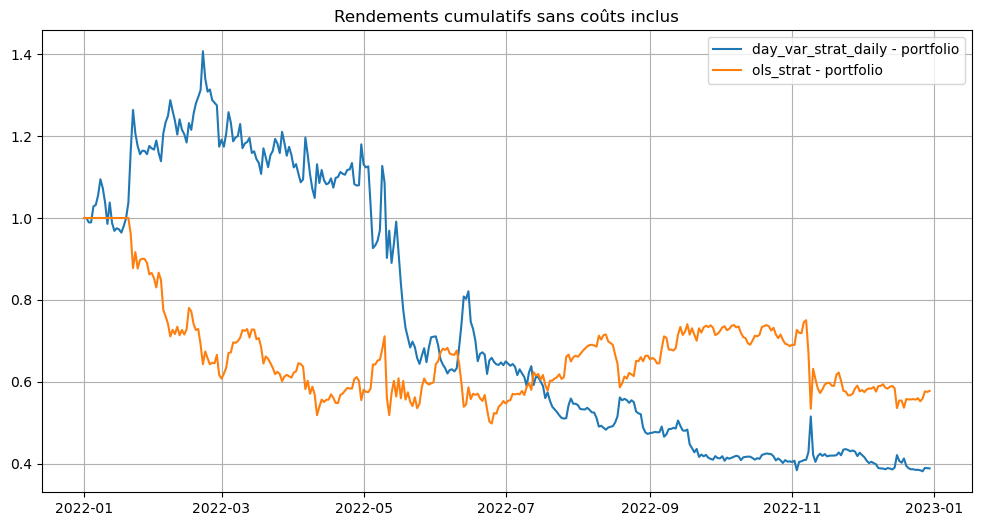

In [12]:
# Graphique des différentes stratégies avec possibilité d'inclusion de coûts 
manager.plot_all_strategies(backend=backend,include_costs=False)
manager2.plot_all_strategies(backend=backend,include_costs=False)

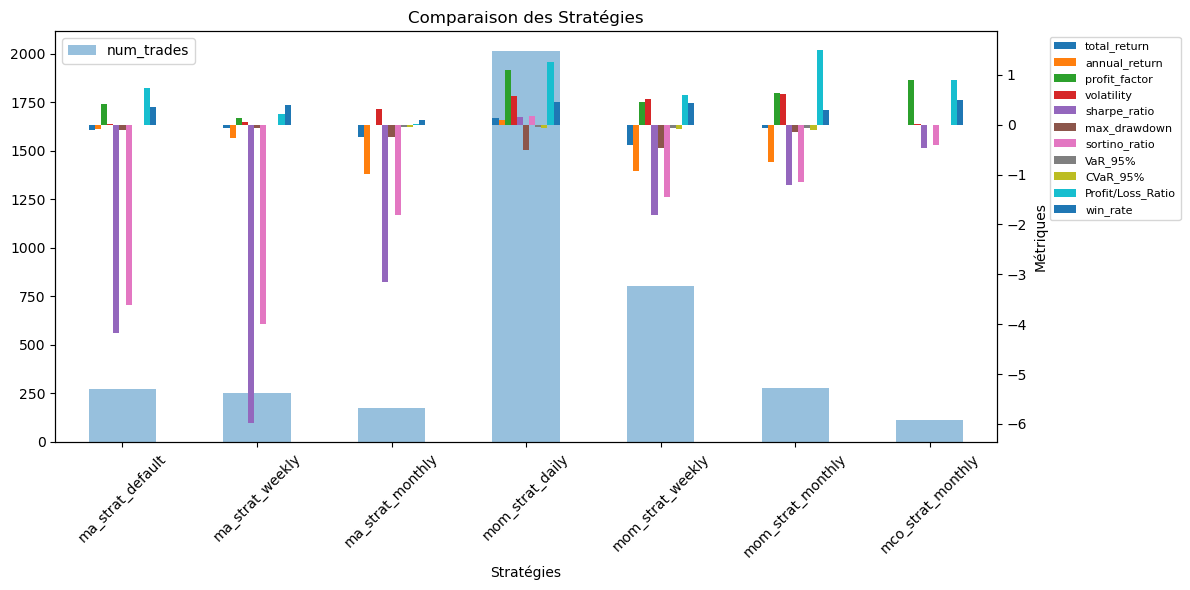

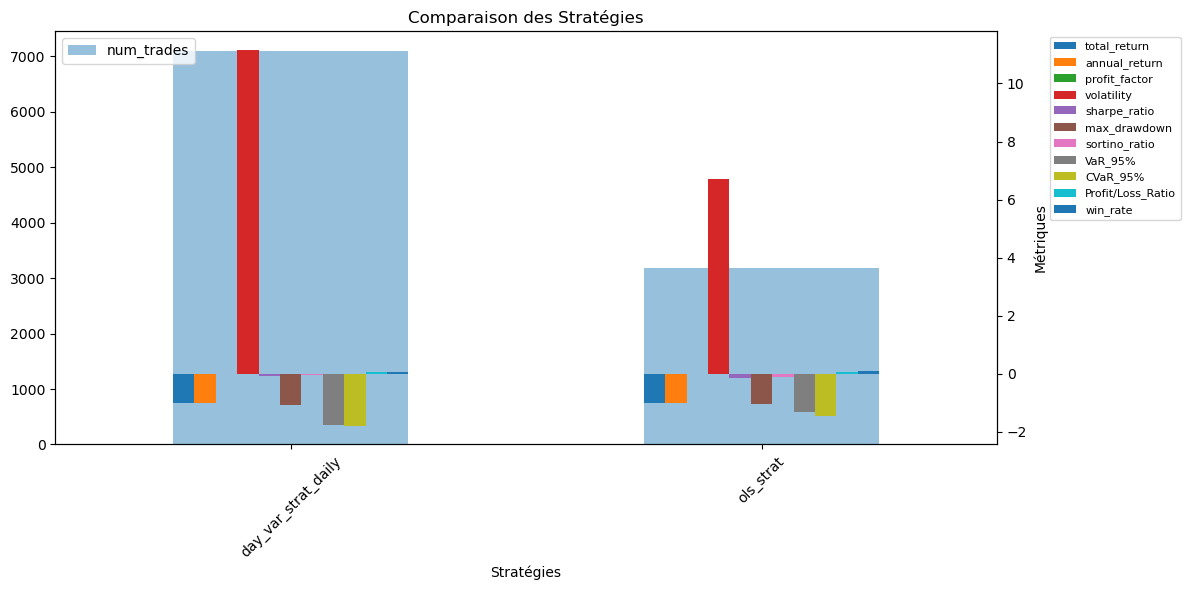

In [13]:
# Histogramme de comparaison des différentes stratégies
manager.compare_strategies(backend=backend)
manager2.compare_strategies(backend=backend)

### *Analyse rapide des graphiques*

#### **1. Rendements Cumulés avec Coûts Inclus**
- Les rendements cumulés montrent une divergence claire entre les stratégies. La majorité des courbes descendent progressivement, indiquant que les frais de transaction impactent négativement les performances globales.
- Une courbe mom_strat_daily reste stable en début et fin de période, mais très volatile au centre.

#### **2. Rendements Cumulés sans Coûts Inclus**
- En supprimant les coûts, on observe une amélioration notable des performances globales. 
- Cependant, une grande partie des stratégies montre encore une incapacité à générer des rendements constants, indiquant des faiblesses structurelles dans les approches de trading, même en l'absence de frais.

#### **4. Comparaison des Métriques**
- Ce graphique permet de comparer les différentes métriques pour chaque stratégie. Les points marquants incluent :
    - Nombre de Transactions : Les stratégies les plus actives, i.e. fréquence journalière, enregistrent des coûts plus élevés et des rendements moindres, ce qui reflète une fréquence de trading non optimisée.
    - Sharpe Ratio et Profit Factor : Les valeurs sont globalement proche de zéro ou négatives, indiquant une gestion inefficace du risque et des pertes importantes par rapport aux gains.
    - Win Rate : La majorité des stratégies ont un taux de succès inférieur à 50 %, montrant une prédominance de trades non rentables.